In [2]:
import pennylane as qml
import torch
from torch import nn
from torch.utils.data import DataLoader
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pennylane as pl
from sklearn.datasets import fetch_california_housing
import torch
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split 


In [3]:
import sys
sys.path.insert(0, "../")
import utils.utils as utils
import models.fourier_models as fm
import models.relu_model as rl
import models.quantum_models as qm


# Evaluation of the Relu model

In the following we will through one run evaluate the results of the model given the different values of rescaling:
- Rescaling [-pi/2, pi/2]
    -  Use of LBFGS Optimizer
    -  Use of Adam Optimizer
    -  50 and 500 epochs
The evaluation metrics are MARE, R sqaured.



### 1-PreProcessing same as Fourier Model

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch

# Assuming fetch_california_housing is already defined and imported
data = fetch_california_housing()
X = torch.from_numpy(data.data).float()
y = torch.from_numpy(data.target).float()

# Split the dataset into training + validation and testing (hold-out set)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

# Further split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=2)  # 25% of X_train_val will be X_val

# Now we scale the data, ensuring no data leakage happens

# Calculate scaling parameters (min and max in this case) only from the training set
min_value, max_value = X_train.min(dim=0)[0], X_train.max(dim=0)[0]

# Scale the training data
X_train_scaled = utils.data_scaler(X_train, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))

# Apply the same scaling to the validation and test data
X_val_scaled = utils.data_scaler(X_val, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))
X_test_scaled = utils.data_scaler(X_test, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))


# Create TensorDatasets and DataLoaders with the scaled data
train_dataset = TensorDataset(X_train_scaled, y_train)
val_dataset = TensorDataset(X_val_scaled, y_val)
test_dataset = TensorDataset(X_test_scaled, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=500)
test_dataloader = DataLoader(test_dataset, batch_size=500)

## 2- Trainning Loop for LBFGS optimizer

In [5]:
# Define training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    num_batches = len(dataloader)

    for X, y in dataloader:
        # Define the closure function
        def closure():
            optimizer.zero_grad()
            output = model(X)
            loss = loss_fn(output.squeeze(), y)  # Compute loss
            loss.backward()  # Perform backpropagation
            return loss

        loss = closure()  # Compute the loss and perform backpropagation
        optimizer.step(closure)  # Update model parameters using the optimizer

        total_loss += loss.item()  # Accumulate the loss

    average_loss_per_batch = total_loss / num_batches  # Calculate the average loss
    return average_loss_per_batch


# Define evaluation function for both validation and test sets
def evaluate(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_absolute_relative_error = 0
    predictions, targets = [], []
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            output = model(X).squeeze()  # Squeeze the output here as well
            loss = loss_fn(output, y)
            total_loss += loss.item()
            total_absolute_relative_error += torch.abs((y - output) / torch.clamp(y, min=1e-6)).sum().item()
            predictions.extend(output.tolist())
            targets.extend(y.tolist())

    # Calculate average loss and error metrics per batch
    average_loss = total_loss / num_batches
    avg_mare = total_absolute_relative_error / len(dataloader.dataset)  # MARE over the entire dataset
    r2 = r2_score(targets, predictions)  # R² score

    return average_loss, avg_mare, r2



## 3-Using LBFGS Optimizer
- using 96 neurones per layer 
- MSE / MARE / Rsquared

Epoch 1
-------------------------------
Train Loss: 0.6878
Validation Loss: 0.4101, MARE: 0.2475, R-squared: 0.6875
Epoch 2
-------------------------------
Train Loss: 0.4279
Validation Loss: 0.4133, MARE: 0.2620, R-squared: 0.6828
Epoch 3
-------------------------------
Train Loss: 0.4210
Validation Loss: 0.4030, MARE: 0.2469, R-squared: 0.6916
Epoch 4
-------------------------------
Train Loss: 0.4063
Validation Loss: 0.4129, MARE: 0.2533, R-squared: 0.6836
Epoch 5
-------------------------------
Train Loss: 0.4072
Validation Loss: 0.4213, MARE: 0.2688, R-squared: 0.6771
Epoch 6
-------------------------------
Train Loss: 0.4078
Validation Loss: 0.4057, MARE: 0.2504, R-squared: 0.6915
Epoch 7
-------------------------------
Train Loss: 0.4002
Validation Loss: 0.3817, MARE: 0.2406, R-squared: 0.7076
Epoch 8
-------------------------------
Train Loss: 0.3974
Validation Loss: 0.3975, MARE: 0.2479, R-squared: 0.6959
Epoch 9
-------------------------------
Train Loss: 0.3977
Validation Lo

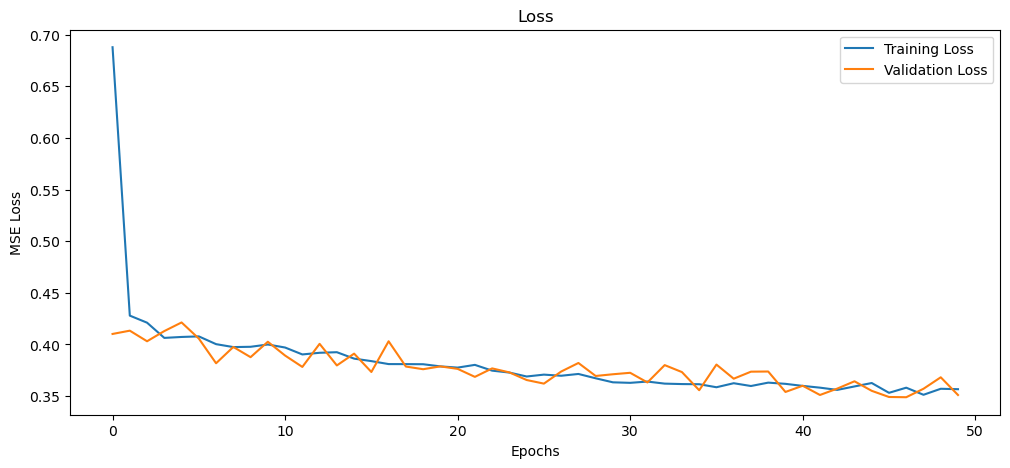

Test Loss: 0.3752, Test MARE: 0.2293, Test R-squared: 0.7178


In [13]:
# Initialize the model
input_dim = X_train.shape[1]
hidden_dim = 96  # You can adjust this
output_dim = 1   # Assuming a single output; adjust if necessary

model = rl.ReLURegressionModel(input_dim , hidden_dim, output_dim ).float()


# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r_squared = []

# Training loop
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r_squared = evaluate(val_dataloader, model, loss_fn)  # Unpack the additional metrics

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r_squared.append(val_r_squared)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, MARE: {val_mare:.4f}, R-squared: {val_r_squared:.4f}")

# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r_squared = evaluate(test_dataloader, model, loss_fn)  # Unpack the additional metrics
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R-squared: {test_r_squared:.4f}")


Epoch 1
-------------------------------
Train Loss: 0.7091
Validation Loss: 0.4233, MARE: 0.2513, R-squared: 0.6739
Epoch 2
-------------------------------
Train Loss: 0.4301
Validation Loss: 0.4098, MARE: 0.2595, R-squared: 0.6861
Epoch 3
-------------------------------
Train Loss: 0.4210
Validation Loss: 0.4117, MARE: 0.2549, R-squared: 0.6827
Epoch 4
-------------------------------
Train Loss: 0.4121
Validation Loss: 0.4050, MARE: 0.2482, R-squared: 0.6897
Epoch 5
-------------------------------
Train Loss: 0.4106
Validation Loss: 0.3973, MARE: 0.2375, R-squared: 0.6963
Epoch 6
-------------------------------
Train Loss: 0.4042
Validation Loss: 0.4123, MARE: 0.2596, R-squared: 0.6841
Epoch 7
-------------------------------
Train Loss: 0.4021
Validation Loss: 0.3980, MARE: 0.2498, R-squared: 0.6957
Epoch 8
-------------------------------
Train Loss: 0.4001
Validation Loss: 0.3988, MARE: 0.2592, R-squared: 0.6935
Epoch 9
-------------------------------
Train Loss: 0.3972
Validation Lo

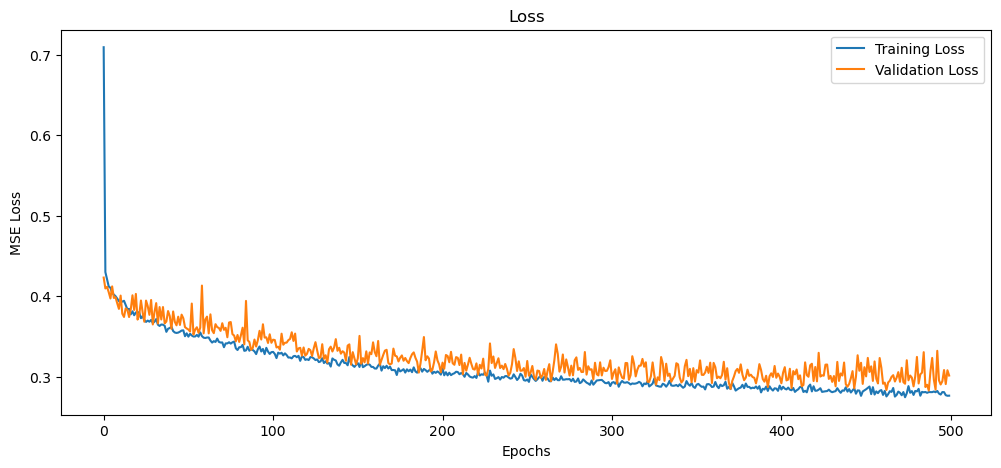

Test Loss: 0.4003, Test MARE: 0.2164, Test R-squared: 0.6938


In [6]:
# Initialize the model
input_dim = X_train.shape[1]
hidden_dim = 96  # You can adjust this
output_dim = 1   # Assuming a single output; adjust if necessary

model = rl.ReLURegressionModel(input_dim , hidden_dim, output_dim ).float()


# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r_squared = []

# Training loop
epochs = 500
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r_squared = evaluate(val_dataloader, model, loss_fn)  # Unpack the additional metrics

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r_squared.append(val_r_squared)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, MARE: {val_mare:.4f}, R-squared: {val_r_squared:.4f}")

# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r_squared = evaluate(test_dataloader, model, loss_fn)  # Unpack the additional metrics
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R-squared: {test_r_squared:.4f}")


## 4-Using Adam optimizer
##### 4.a-Without adjusting the training function.
- using 96 neurones per layer 
- MSE / MARE / Rsquared


Epoch 1
-------------------------------
Train Loss: 1.3881
Validation Loss: 0.5864, MARE: 0.4252, R-squared: 0.5531
Epoch 2
-------------------------------
Train Loss: 0.5543
Validation Loss: 0.4906, MARE: 0.2901, R-squared: 0.6243
Epoch 3
-------------------------------
Train Loss: 0.5102
Validation Loss: 0.4657, MARE: 0.2846, R-squared: 0.6437
Epoch 4
-------------------------------
Train Loss: 0.4820
Validation Loss: 0.4451, MARE: 0.2711, R-squared: 0.6596
Epoch 5
-------------------------------
Train Loss: 0.4732
Validation Loss: 0.4412, MARE: 0.2730, R-squared: 0.6625
Epoch 6
-------------------------------
Train Loss: 0.4746
Validation Loss: 0.4477, MARE: 0.2925, R-squared: 0.6584
Epoch 7
-------------------------------
Train Loss: 0.4654
Validation Loss: 0.4349, MARE: 0.2805, R-squared: 0.6679
Epoch 8
-------------------------------
Train Loss: 0.4575
Validation Loss: 0.4223, MARE: 0.2551, R-squared: 0.6768
Epoch 9
-------------------------------
Train Loss: 0.4487
Validation Lo

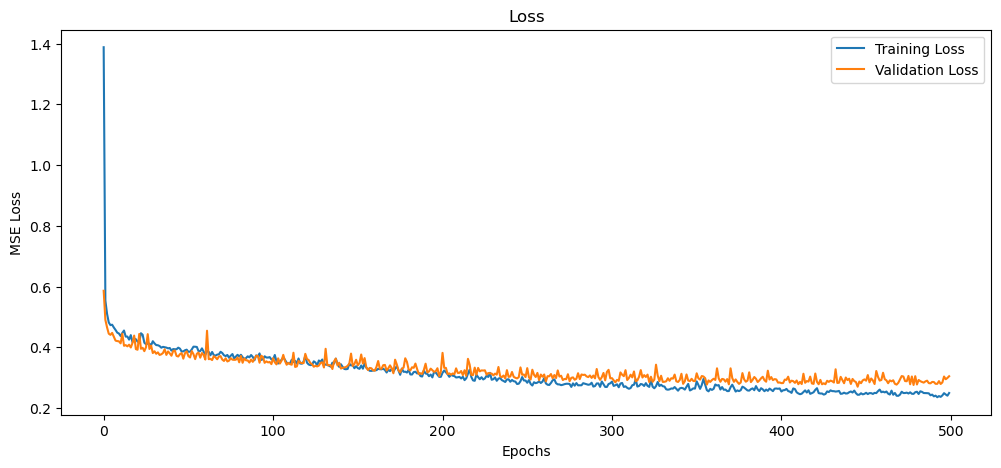

Test Loss: 0.3181, Test MARE: 0.1971, Test R-squared: 0.7600


In [20]:
# Initialize the model
input_dim = X_train.shape[1]
hidden_dim = 96  # You can adjust this
output_dim = 1   # Assuming a single output; adjust if necessary

model = rl.ReLURegressionModel(input_dim , hidden_dim, output_dim ).float()


# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r_squared = []

# Training loop
epochs = 500
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r_squared = evaluate(val_dataloader, model, loss_fn)  # Unpack the additional metrics

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r_squared.append(val_r_squared)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, MARE: {val_mare:.4f}, R-squared: {val_r_squared:.4f}")

# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r_squared = evaluate(test_dataloader, model, loss_fn)  # Unpack the additional metrics
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R-squared: {test_r_squared:.4f}")


#### 4.b-Adjusting the training function.
same hyperparameters

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    num_batches = len(dataloader)

    for X, y in dataloader:
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output.squeeze(), y)  # Compute loss
        loss.backward()  # Perform backpropagation
        optimizer.step()  # Update model parameters using the optimizer

        total_loss += loss.item()

    average_loss = total_loss / num_batches
    return average_loss

# Define evaluation function for both validation and test sets
def evaluate(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_absolute_relative_error = 0
    predictions, targets = [], []
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            output = model(X).squeeze()  # Squeeze the output here as well
            loss = loss_fn(output, y)
            total_loss += loss.item()
            total_absolute_relative_error += torch.abs((y - output) / torch.clamp(y, min=1e-6)).sum().item()
            predictions.extend(output.tolist())
            targets.extend(y.tolist())

    # Calculate average loss and error metrics per batch
    average_loss = total_loss / num_batches
    avg_mare = total_absolute_relative_error / len(dataloader.dataset)  # MARE over the entire dataset
    r2 = r2_score(targets, predictions)  # R² score

    return average_loss, avg_mare, r2

- using 96 neurones per layer 
- lr = 0.01

Epoch 1
-------------------------------
Train Loss: 1.1788
Validation Loss: 0.5530, MARE: 0.3205, R-squared: 0.5758
Epoch 2
-------------------------------
Train Loss: 0.5489
Validation Loss: 0.4940, MARE: 0.3066, R-squared: 0.6232
Epoch 3
-------------------------------
Train Loss: 0.5142
Validation Loss: 0.4718, MARE: 0.3003, R-squared: 0.6399
Epoch 4
-------------------------------
Train Loss: 0.4927
Validation Loss: 0.4611, MARE: 0.2650, R-squared: 0.6476
Epoch 5
-------------------------------
Train Loss: 0.4911
Validation Loss: 0.4821, MARE: 0.3327, R-squared: 0.6322
Epoch 6
-------------------------------
Train Loss: 0.4888
Validation Loss: 0.4419, MARE: 0.2519, R-squared: 0.6620
Epoch 7
-------------------------------
Train Loss: 0.4725
Validation Loss: 0.4358, MARE: 0.2762, R-squared: 0.6673
Epoch 8
-------------------------------
Train Loss: 0.4637
Validation Loss: 0.4333, MARE: 0.2479, R-squared: 0.6684
Epoch 9
-------------------------------
Train Loss: 0.4719
Validation Lo

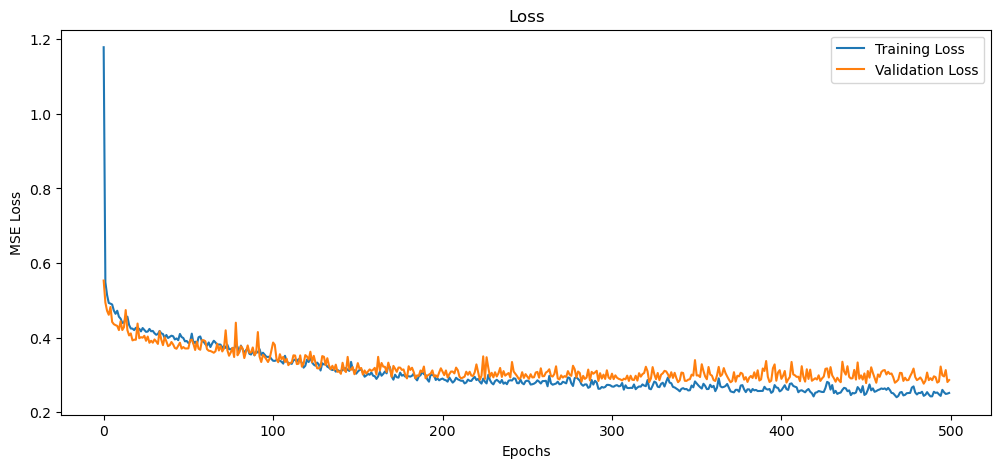

Test Loss: 0.2892, Test MARE: 0.1961, Test R-squared: 0.7799


In [9]:
# Initialize the model
input_dim = X_train.shape[1]
hidden_dim = 96  # You can adjust this
output_dim = 1   # Assuming a single output; adjust if necessary

model = rl.ReLURegressionModel(input_dim , hidden_dim, output_dim ).float()


# Define the loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  

# Prepare lists to store loss and evaluation metrics
NN_loss = []
NN_val_loss = []
NN_val_mare = []
NN_val_r_squared = []

# Training loop
epochs = 500
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_mare, val_r_squared = evaluate(val_dataloader, model, loss_fn)  # Unpack the additional metrics

    NN_loss.append(train_loss)
    NN_val_loss.append(val_loss)
    NN_val_mare.append(val_mare)
    NN_val_r_squared.append(val_r_squared)

    # Print out the metrics for the current epoch
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, MARE: {val_mare:.4f}, R-squared: {val_r_squared:.4f}")

# Plot the training and validation losses
x = np.arange(0, epochs)
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.plot(x, NN_loss, label="Training Loss")
plt.plot(x, NN_val_loss, label="Validation Loss")
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_mare, test_r_squared = evaluate(test_dataloader, model, loss_fn)  # Unpack the additional metrics
print(f"Test Loss: {test_loss:.4f}, Test MARE: {test_mare:.4f}, Test R-squared: {test_r_squared:.4f}")
